In [234]:
import sys, os, fnmatch, datetime, subprocess, imp
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from maxentpy import maxent_fast as ment
from maxentpy.maxent_fast import load_matrix
import math
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
fpath = os.getcwd()[:-3]
DATADIR = os.path.join(fpath, 'data')

In [4]:
match_dct = {
    'A':'T',
    'C':'G',
    'T':'A',
    'G':'C',
}

In [5]:
def reverse_complement(umi):
    if len(umi) == 0:
        return ''
    try:
        this = match_dct[umi[-1:]]
    except:
        print(umi)
        this = ''
    return this + reverse_complement(umi[:-1])

In [6]:
matrix3 = load_matrix(3)

In [7]:
complete_df = pd.read_csv(os.path.join(DATADIR, 'new_maxent_mers.csv'))

/Users/sophia/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
complete_df = complete_df.drop(['insert_length', 'deletion_length', 'in_genotype', 'target', 'lib'], axis=1)

In [9]:
complete_df['maxent_score'] = complete_df.maxent_mer.apply(lambda x: ment.score3(x, matrix=matrix3))

In [10]:
wild_type = pd.read_csv(os.path.join(DATADIR, '061318_exonskipping_library.csv'))

In [11]:
wild_type['sequence_23'] = wild_type['Designed 61-bp target site (37i-24e, AG)'].apply(lambda x: x[17:40])

In [12]:
wild_type['maxent_mer'] = wild_type['Designed 61-bp target site (37i-24e, AG)'].apply(lambda x: ment.score3(x[17:40], matrix = matrix3))

In [13]:
wild_type = wild_type.rename(columns={'Identifier number':'id'})

In [14]:
wild_type_dict = pd.Series(wild_type.maxent_mer.values, index=wild_type.id).to_dict()

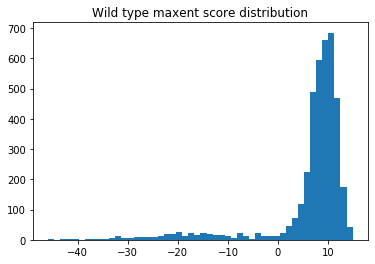

In [15]:
plot = plt.hist(wild_type.maxent_mer, bins=50)
txt = plt.title('Wild type maxent score distribution')

## Q: What if we only looked at insertions?

Most insertions should have maxent scores very similar to those of wild type

In [38]:
insertion = complete_df.loc[complete_df.Category == 'ins']
ins_percentage = insertion.groupby(['library_key'])['Predicted frequency'].sum().reset_index('library_key')
ins_percentage_dict = pd.Series(ins_percentage['Predicted frequency'].values, index = ins_percentage.library_key).to_dict()

In [39]:
insertion['Predicted frequency'] = insertion.apply(lambda x: x['Predicted frequency']/ins_percentage_dict[x.library_key], axis=1)

/Users/sophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
insertion['score'] = insertion.maxent_score * insertion['Predicted frequency']

/Users/sophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


This is a histogram of insertion scores, y axis contains number of gRNAs with that score

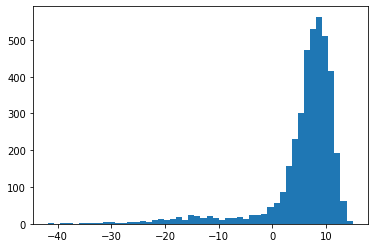

In [41]:
ins_weighted = insertion.groupby('library_key')['score'].sum()
ins_weighted = ins_weighted.reset_index('library_key').rename(columns={'library_key':'id'})
plot = plt.hist(ins_weighted.score, bins=50)

In [42]:
ins_weighted['wild_type'] = ins_weighted.id.apply(lambda x: wild_type_dict[x])

this plot should tell us whether or not the maxent scores are consistent

0.88

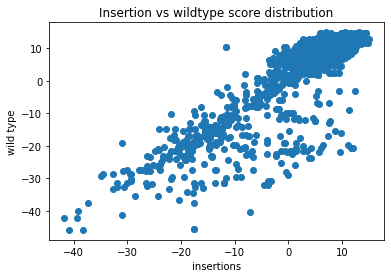

In [44]:
plot = plt.scatter(ins_weighted.score, ins_weighted.wild_type)
plt.xlabel('insertions')
plt.ylabel('wild type')
plt.title('Insertion vs wildtype score distribution')
round(np.corrcoef(ins_weighted.score, ins_weighted.wild_type)[0,1],2)

## Processing all maxent data - deletions and insertions

In [16]:
total_percentage = complete_df.groupby(['library_key'])['Predicted frequency'].sum().reset_index('library_key')
total_percentage_dict = pd.Series(total_percentage['Predicted frequency'].values, index = total_percentage.library_key).to_dict()

In [17]:
complete_df['Predicted frequency'] = complete_df.apply(lambda x: x['Predicted frequency']/total_percentage_dict[x.library_key], axis=1)

In [18]:
complete_df['score'] = complete_df.maxent_score * complete_df['Predicted frequency']

In [19]:
df = complete_df.groupby('library_key')['score'].sum()

In [20]:
df = df.reset_index('library_key').rename(columns={'library_key':'id'})

In [21]:
df.score.sort_values()

2763   -34.171534
1729   -31.564524
2764   -30.281250
2406   -29.465168
2258   -28.507211
2024   -28.204206
583    -27.941034
1254   -27.823680
1442   -27.625488
1441   -27.314327
3807   -26.636431
3613   -25.823744
2323   -25.655183
2257   -25.592601
1987   -25.507725
1800   -25.378748
2217   -25.362315
2218   -25.257026
2256   -25.245251
579    -24.965326
2749   -24.660501
2755   -24.215694
2407   -23.977831
1190   -23.280036
1820   -23.092130
3262   -23.062085
779    -22.736202
2284   -22.569296
1851   -22.471070
1772   -22.252737
          ...    
3329     8.491615
993      8.497657
3878     8.568028
1888     8.595031
615      8.607984
1368     8.652620
826      8.767913
208      8.796466
753      8.800585
2724     8.852204
771      9.015113
3684     9.024705
1790     9.074569
2236     9.106419
1198     9.132325
3929     9.247279
33       9.341122
678      9.359476
159      9.523232
34       9.584880
2144     9.653696
2027     9.798575
3718     9.821700
728      9.881608
2442    10

In [22]:
df['wild_type'] = df.id.apply(lambda x: wild_type_dict[x])

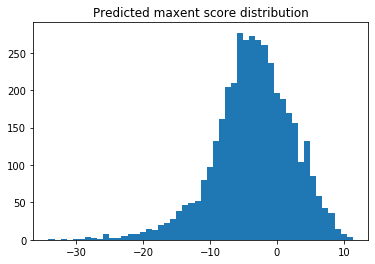

In [52]:
plot = plt.hist(df.score, bins=50)
txt = plt.title('Predicted maxent score distribution')

Another way of calculating a probability (instead of score): everything above a certain threshold ==> spliced. Weighted average of spliced versus unspliced --> probability for each gRNA/target pair. How to choose threshold? From wildtype?

0.51

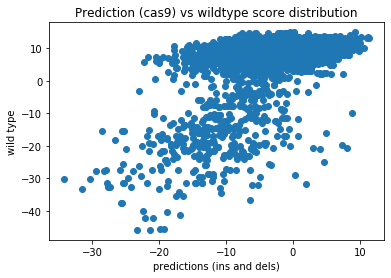

In [53]:
plot = plt.scatter(df.score, df.wild_type)
plt.xlabel('predictions (ins and dels)')
plt.ylabel('wild type')
plt.title('Prediction (cas9) vs wildtype score distribution')
round(np.corrcoef(df.score, df.wild_type)[0,1],2)

## Import all b6 probabilities

In [23]:
b6 = pd.read_csv(os.path.join(DATADIR, 'b6_match_all.csv'))
b6 = b6.drop('id', axis=1).rename(columns={'real_id':'id'})

In [24]:
b6_precas9 = pd.read_csv(os.path.join(DATADIR, 'b6_pre_processed_all.csv'))

In [25]:
def b_count(b6_match):
    b6_ids = b6_match.id.unique()
    all_scores = b6_match.groupby('id')['slice_type'].value_counts(normalize=True).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('id').rename(columns = {0:'percent'})
    b_scores = all_scores.loc[lambda x: x.slice_type == 'b']
    b_score_dict = pd.Series(b_scores.slice_type.values, index = b_scores.id).to_dict()
    for x in b6_ids:
        if x not in b_score_dict:
            b_scores = b_scores.append({'id':x, 'slice_type':'b', 'percent': 0.0}, ignore_index=True)
    return b_scores

In [26]:
def c_count(b6_match):
    b6_ids = b6_match.id.unique()
    all_scores = b6_match.groupby('id')['slice_type'].value_counts(normalize=True).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('id').rename(columns = {0:'percent'})
    c_scores = all_scores.loc[lambda x: x.slice_type == 'c']
    c_score_dict = pd.Series(c_scores.slice_type.values, index = c_scores.id).to_dict()
    for x in b6_ids:
        if x not in c_score_dict:
            c_scores = c_scores.append({'id':x, 'slice_type':'c', 'percent': 0.0}, ignore_index=True)
    return c_scores

In [27]:
def log_to_prob(log):
    return math.exp(log)/(1 + math.exp(log))

In [59]:
b6.groupby('slice_type').size()

slice_type
b          107491
c           65496
cryptic     11841
dtype: int64

In [28]:
b6_filtered = b6.set_index('id').sort_index().join(wild_type.set_index('id'))

In [29]:
b6_c_fractions = b6_filtered.groupby('id').apply(lambda x: x.slice_type.value_counts().loc['c']/(x.slice_type.value_counts().loc['c']+x.slice_type.value_counts().loc['b'])
                                      if ('b' in x.slice_type.values) & ('c' in x.slice_type.values)
                                        else np.nan).rename("b6_c_fractions")

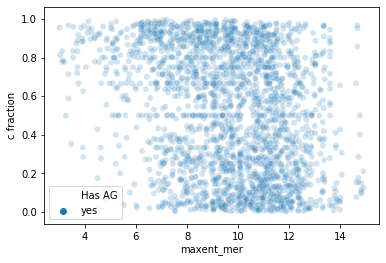

In [30]:
sns.scatterplot(data = b6_filtered.join(b6_c_fractions.rename('c fraction')).reset_index().drop_duplicates('id').loc[lambda x:x.maxent_mer > 3], alpha =.2, hue='Has AG', y= 'c fraction',x = 'maxent_mer')

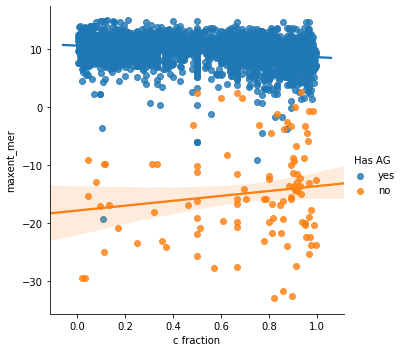

In [32]:
sns.lmplot(data = b6_filtered.join(b6_c_fractions.rename('c fraction')).reset_index().drop_duplicates('id'), hue='Has AG', x = 'c fraction', y = 'maxent_mer')

In [174]:
b3c = pd.read_csv("b3_cas9.csv")

In [179]:
b3c.loc[lambda x:x.genotype == 'del'].groupby("umi").genotype.value_counts()

umi              genotype
AAAAAAAATAACAAT  del         12
AAAAAAACTAGTACC  del          2
AAAAAAACTCACGCG  del          1
AAAAAAACTCTGCCA  del          5
AAAAAAAGTTATAGT  del          3
AAAAAAAGTTATATT  del          1
AAAAAACCCGACGGA  del          1
AAAAAACCCGAGGCA  del         22
AAAAAACCTCCCGAA  del          9
AAAAAACGTACTATA  del          1
AAAAAACTAACATAT  del          1
AAAAAACTGAGCTTG  del          9
AAAAAAGATATTTTT  del          5
AAAAAAGTAATTTTG  del          1
AAAAAAGTTGGCTAG  del          1
AAAAAATCTTTTGCT  del          1
AAAAAATGGCATGTT  del          3
AAAAAATTTCGGCAA  del          7
AAAAACCAACCGACA  del         30
AAAAACCACAATTCT  del          1
AAAAACCCTGTGGGG  del          2
AAAAACGAGGCGCGA  del          1
AAAAACTACGCTGTG  del         49
AAAAACTAGCGGAGG  del          2
AAAAAGAACTTTGTG  del         30
AAAAAGAGAGCTCCA  del          1
AAAAAGATACTTTAC  del          1
AAAAAGATAGCCTCC  del         18
AAAAAGATCATAAAT  del          4
AAAAAGATTGATCAT  del          1
              

In [171]:
b3m = pd.read_csv("b3_match.csv")

In [170]:
len(b3.drop_duplicates(subset=["umi"]))

1204501

In [169]:
len(b3.drop_duplicates())

2218103

In [167]:
len(b3)

16137320

In [163]:
len(b6[["umi"]].drop_duplicates())

27586

In [162]:
len(b6[["slice_type","umi"]].drop_duplicates())

36042

In [159]:
(len(b6),b6.umi.nunique())

(184828, 27586)

## Threshold - Sigmoid Plot

Currently plotting wild type maxent scores against c splicing results of actual data - should I use another set of maxent scores?

In [33]:
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

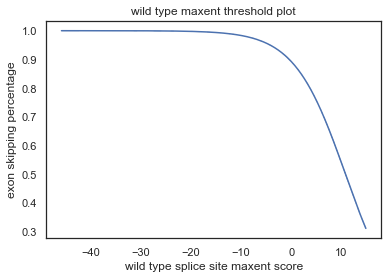

In [257]:
wild_popt, wild_pcov = curve_fit(fsigmoid, c_prob['wild_type frequency'], c_prob.percent, [-30, 1])
wild_threshold_plot = sns.lineplot(c_prob['wild_type frequency'], fsigmoid(c_prob['wild_type frequency'], *wild_popt))
title = wild_threshold_plot.set_title('wild type maxent threshold plot')
label_axes = wild_threshold_plot.set(xlabel = 'wild type splice site maxent score', ylabel = 'exon skipping percentage')

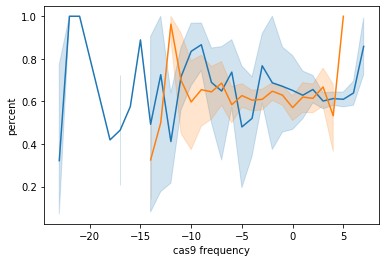

In [56]:
sns.lineplot(c_prob['wild_type frequency']//2, c_prob.percent)
sns.lineplot(c_prob['cas9 frequency']//2, c_prob.percent)

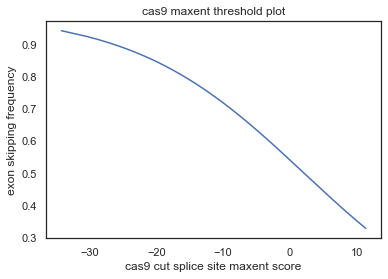

In [258]:
popt, pcov = curve_fit(fsigmoid, c_prob['cas9 frequency'], c_prob.percent, [-30, 0.9])
threshold_plot = sns.lineplot(c_prob['cas9 frequency'], fsigmoid(c_prob['cas9 frequency'], *popt))
title = threshold_plot.set_title('cas9 maxent threshold plot')
label_axes = threshold_plot.set(xlabel = 'cas9 cut splice site maxent score', ylabel = 'exon skipping frequency')

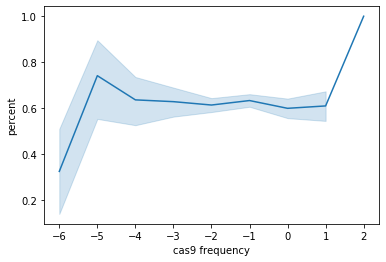

In [54]:
sns.lineplot(c_prob['cas9 frequency']//5, c_prob.percent)

## Plotting probability of c splice against maxent scores

In [84]:
c_prob = c_count(b6)

In [85]:
c_prob = c_prob.set_index('id').join(pd.Series(df.wild_type.values, index = df.id).rename('wild_type frequency'))

In [86]:
c_prob = c_prob.join(pd.Series(df.score.values, index = df.id).rename('cas9 frequency'))

(0, 1)

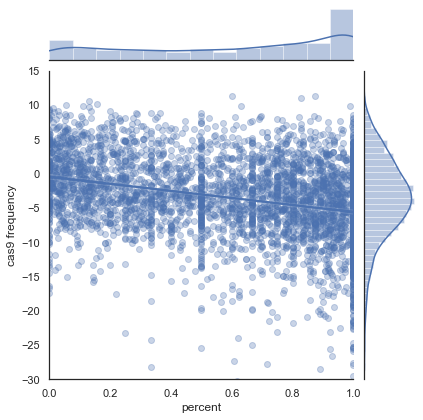

In [250]:
sns.jointplot(c_prob.percent, c_prob['cas9 frequency'], kind = 'reg', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_ylim([-30,15])
ax.set_xlim([0,1])

(0, 1)

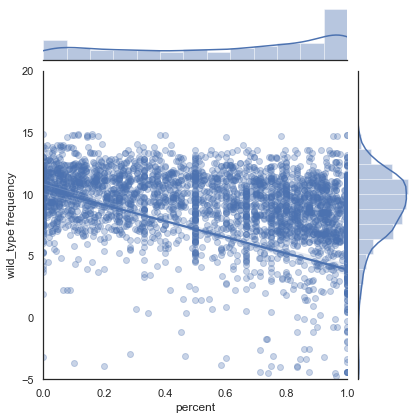

In [151]:
sns.jointplot(c_prob.percent, c_prob['wild_type frequency'], kind = 'reg', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_ylim([-5,20])
ax.set_xlim([0,1])

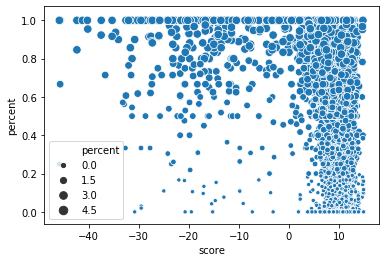

In [113]:
sns.scatterplot(x='score', y='percent', data = c_probability, size=c_probability.percent.apply(lambda x: x//.2))

## Pre Cas9 Plots:

In [214]:
c_precas9_prob = c_count(b6_precas9)

In [215]:
c_precas9_prob = c_precas9_prob.set_index('id').join(pd.Series(df.wild_type.values, index = df.id).rename('wild_type frequency'))
c_precas9_prob = c_precas9_prob.join(pd.Series(df.score.values, index = df.id).rename('cas9 frequency'))

(0, 1)

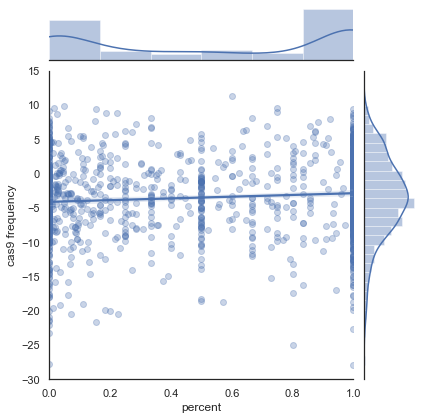

In [153]:
sns.jointplot(c_precas9_prob.percent, c_precas9_prob['cas9 frequency'], kind = 'reg', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_ylim([-30,15])
ax.set_xlim([0,1])

(0, 1)

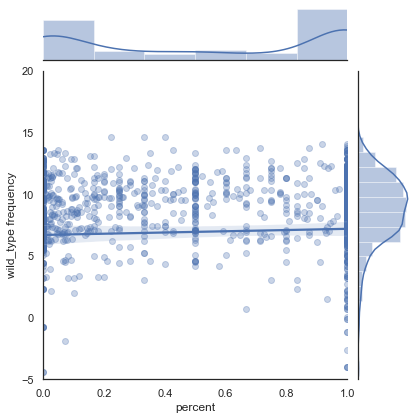

In [154]:
sns.jointplot(c_precas9_prob.percent, c_precas9_prob['wild_type frequency'], kind = 'reg', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_ylim([-5,20])
ax.set_xlim([0,1])

In [96]:
b6.shape[0]

184828

## Four plot figure

(0, 1)

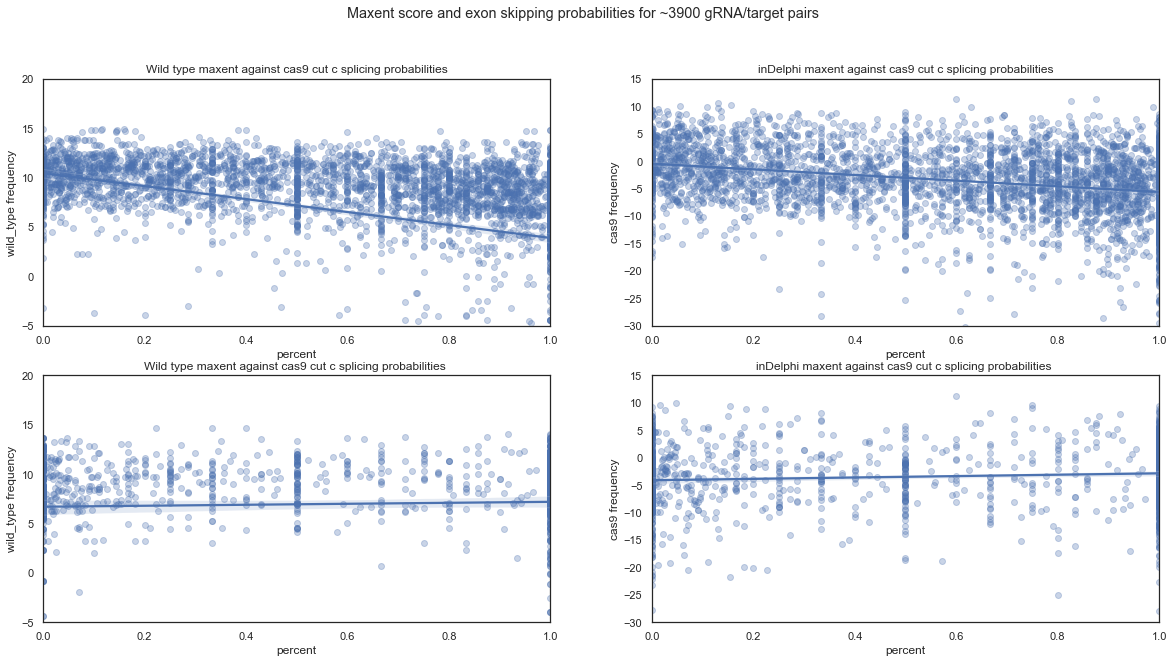

In [178]:
fig, axes = plt.subplots(2, 2)

fig.suptitle('Maxent score and exon skipping probabilities for ~3900 gRNA/target pairs')

fig.set_size_inches(20,10)

ax1 = axes[0,0] 
sns.regplot(c_prob.percent, c_prob['wild_type frequency'], scatter_kws={'alpha':0.3}, 
            ax = ax1, color = 'b').set_title('Wild type maxent against cas9 cut c splicing probabilities')
ax1.set_ylim([-5,20])
ax1.set_xlim([0,1])

ax2 = axes[0,1]
sns.regplot(c_prob.percent, c_prob['cas9 frequency'], scatter_kws={'alpha':0.3}, 
            ax = axes[0,1], color = 'b').set_title('inDelphi maxent against cas9 cut c splicing probabilities')
ax2.set_ylim([-30,15])
ax2.set_xlim([0,1])

ax3 = axes[1,1]
sns.regplot(c_precas9_prob.percent, c_precas9_prob['cas9 frequency'], scatter_kws={'alpha':0.3}, 
            ax = ax3, color = 'b').set_title('inDelphi maxent against cas9 cut c splicing probabilities ')
ax3.set_ylim([-30,15])
ax3.set_xlim([0,1])

ax4 = axes[1,0]
sns.regplot(c_precas9_prob.percent, c_precas9_prob['wild_type frequency'], scatter_kws={'alpha':0.3}, 
            ax = ax4, color = 'b').set_title('Wild type maxent against cas9 cut c splicing probabilities ')
ax4.set_ylim([-5,20])
ax4.set_xlim([0,1])

In [75]:
b6_readcount = b6.groupby('id')['slice_type'].size().rename(columns = {'slice_type':'counts'}).reset_index().rename(columns = {0:'read_count'})

In [76]:
c_prob_readcount = c_prob.join(pd.Series(b6_readcount.read_count.values, index = b6_readcount.id).rename('read_count'))

In [45]:
c_prob_readcount.loc[(c_prob_readcount.read_count > 20)]

,id,slice_type,percent,wild_type frequency,cas9 frequency,read_count
28,82,c,1.000000,8.480773,3.110513,126.0
29,83,c,0.125000,8.016747,4.786833,33.0
39,110,c,0.812500,9.543876,-3.809639,36.0
51,151,c,0.071429,6.990461,-5.072413,35.0
67,212,c,0.973684,6.229023,-3.458555,111.0
68,213,c,0.970588,6.229023,-4.719058,31.0
71,227,c,0.147287,7.541427,0.083252,62.0
72,228,c,0.057971,7.541427,-3.223171,110.0
74,233,c,0.615385,10.848006,0.390693,193.0
75,234,c,0.666667,7.986310,-7.369970,34.0


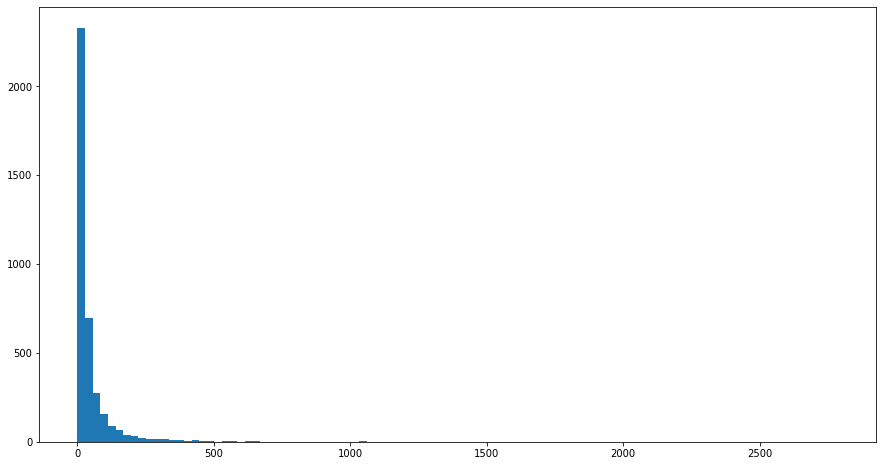

In [239]:
plt.figure(figsize=(15,8))
plot = plt.hist(c_prob_readcount.read_count, bins = 100)

In [274]:
c_prob_readcount.loc[(c_prob_readcount.read_count == 1) & (c_prob_readcount.percent == 1)]

,slice_type,percent,wild_type frequency,cas9 frequency,read_count
id,,,,,
436,c,1.0,7.387868,-15.690081,1
611,c,1.0,10.351745,-4.689580,1
640,c,1.0,6.252502,-2.860946,1
1096,c,1.0,7.070915,-5.154347,1
1164,c,1.0,9.822509,-0.521466,1
1186,c,1.0,4.390114,-5.576685,1
1400,c,1.0,8.762774,-4.310815,1
1428,c,1.0,-27.457353,-27.941034,1
1436,c,1.0,6.961116,-12.539740,1


## Does read count differ with exon splicing percentage?

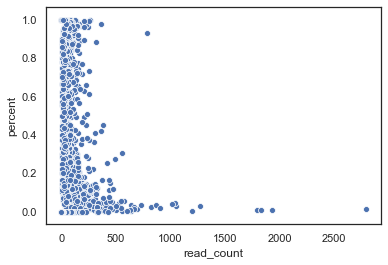

In [285]:
sns.scatterplot(data = c_prob_readcount, x = 'read_count', y = 'percent')

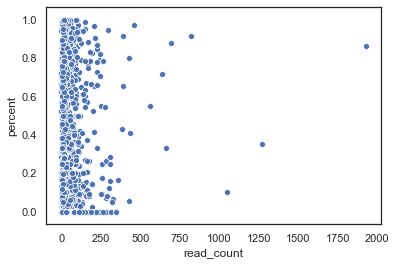

In [287]:
b_prob = b_count(b6)
b_prob_readcount = b_prob.join(pd.Series(b6_readcount.read_count.values, index = b6_readcount.id).rename('read_count'))
sns.scatterplot(data = b_prob_readcount, x = 'read_count', y = 'percent')

## Cutside distance from splice location - skipping rate pre and post cas9

splicing location as defined as between intron and exon: NNNNN.....AG | NNNNNN...

In [104]:
c_prob = c_prob.join(pd.Series(complete_df.cutsite.values, index = complete_df.library_key)
            .reset_index().drop_duplicates('library_key').set_index('library_key')).rename(columns = {0:'cutsite'})

In [122]:
wild_type['splice_location'] = wild_type.apply(lambda x: x.Sequence.find(x['Designed 61-bp target site (37i-24e, AG)'][:30])+37, axis=1)

In [126]:
c_prob = c_prob.join(pd.Series(wild_type.splice_location.values, index = wild_type.id).rename('splice_location'))

In [211]:
c_prob['distance'] = abs(c_prob.cutsite - (c_prob.splice_location-1))

Expect to see a higher percentage of skipping when cutsite is closer to AG

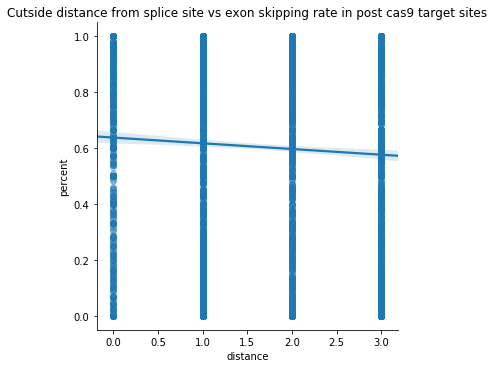

In [242]:
sns.lmplot(data = c_prob, x = 'distance', y = 'percent', scatter_kws={'alpha':0.3})
ax = plt.gca()
title = ax.set_title('Cutside distance from splice site vs exon skipping rate in post cas9 target sites')

In [216]:
c_precas9_prob = c_precas9_prob.join(pd.Series(complete_df.cutsite.values, index = complete_df.library_key)
            .reset_index().drop_duplicates('library_key').set_index('library_key')).rename(columns = {0:'cutsite'})
c_precas9_prob = c_precas9_prob.join(pd.Series(wild_type.splice_location.values, index = wild_type.id).rename('splice_location'))
c_precas9_prob['distance'] = abs(c_precas9_prob.cutsite - (c_precas9_prob.splice_location-1))

Don't expect to see a pattern with pre cas9 data - the cutsite has no effect on skipping, because cas9 is not introduced

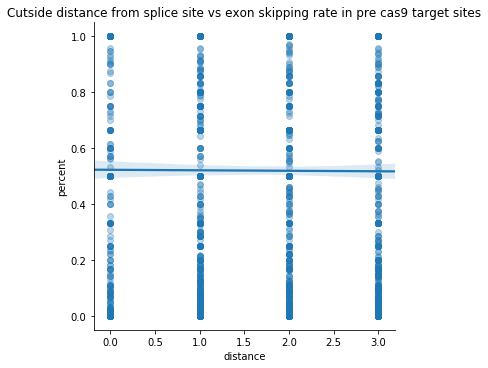

In [244]:
sns.lmplot(data = c_precas9_prob, x = 'distance', y = 'percent', scatter_kws={'alpha':0.3})
ax = plt.gca()
title = ax.set_title('Cutside distance from splice site vs exon skipping rate in pre cas9 target sites')

## change in skipping frequency per target vs change in maxent score 

We don't have skipping frequency for wild type - precas9 data set is very small -- not fully processed

In [179]:
c_mix = c_precas9_prob.join(pd.Series(c_prob.percent.values, index = c_prob.reset_index().id).rename('cas9 percent')).dropna(thresh = 8)

In [180]:
c_mix['skipping_change'] = c_mix['cas9 percent'] - c_mix['percent']

In [185]:
c_mix['maxent_change'] = c_mix['cas9 frequency'] - c_mix['wild_type frequency']

Expect to see greater decrease in maxent number with increase in skipping percentage 

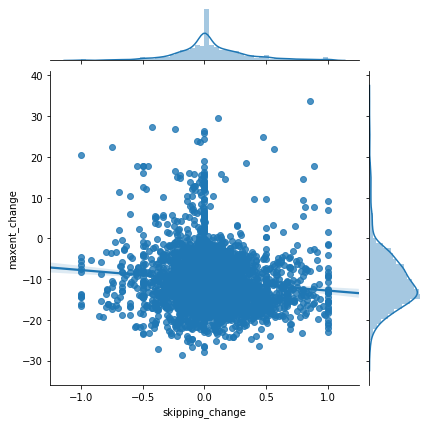

In [250]:
plot = sns.jointplot(data = c_mix, x = 'skipping_change', y = 'maxent_change', kind = 'reg')

In [248]:
c_mix

,slice_type,percent,wild_type frequency,cas9 frequency,cutsite,splice_location,distance,cas9 percent,skipping_change,maxent_change,log_odds_change,log_odds_wild_type,log_odds_cas9
id,,,,,,,,,,,,,
2,c,1.000000,6.123644,-7.511570,68,72,2,0.200000,-0.800000,-13.635213,-9.972679e-01,9.978143e-01,5.464235e-04
6,c,1.000000,3.184193,-0.961183,68,72,2,0.666667,-0.333333,-4.145376,-6.835937e-01,9.602351e-01,2.766414e-01
7,c,1.000000,3.184193,-3.763651,71,72,1,0.785714,-0.214286,-6.947844,-9.375622e-01,9.602351e-01,2.267291e-02
9,c,1.000000,3.184193,-3.990537,74,72,4,0.857143,-0.142857,-7.174730,-9.420810e-01,9.602351e-01,1.815412e-02
12,c,0.900000,8.596525,-11.026863,71,72,1,0.692308,-0.207692,-19.623388,-9.997990e-01,9.998153e-01,1.625876e-05
13,c,1.000000,8.596525,-10.740007,72,72,2,0.933333,-0.066667,-19.336533,-9.997936e-01,9.998153e-01,2.166031e-05
28,c,0.083333,8.480773,3.110513,73,72,3,0.087302,0.003968,-5.370260,-4.246832e-02,9.997926e-01,9.573243e-01
29,c,0.100000,8.016747,4.786833,73,72,3,0.060606,-0.039394,-3.229914,-7.940085e-03,9.996702e-01,9.917301e-01
39,c,1.000000,9.543876,-3.809639,70,72,0,0.888889,-0.111111,-13.353515,-9.782524e-01,9.999284e-01,2.167592e-02
